## Module 2: Image Processing

In this notebook, I will explore different methods to transform input images into clearer, easier to analyze output images.


### Section 1: Introduction

In this section, I will cover topics including
1. Pixel Processing
2. Linear Shift-Invariant Systems and Convolutions
3. Linear Image Filters
4. Non-Linear Image Filters
5. Template Matching by Correlation

In [1]:
%load_ext autoreload
%autoreload 2

In [233]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

**Pixel Processing**

Let $f$ be a function that represents an image with the value at $f(x, y)$ being the intensity value at the point (x, y). We can then define a transformation T s.t. $g(x,y) = T(f(x,y))$ where g is the function representing a new image. 

T can darken, lighten, and invert the image as well as decrease/increase the image's contrast or even grayscale the image.

[Tyler the creator](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fvariety.com%2Fwp-content%2Fuploads%2F2014%2F03%2Ftyler-the-creator1.jpg%3Fresize%3D450&f=1&nofb=1&ipt=59ec17da8aa227625ea538f95e54ba718c127af08eb272a258d002cf456b53d9&ipo=images) will be our muse today :)

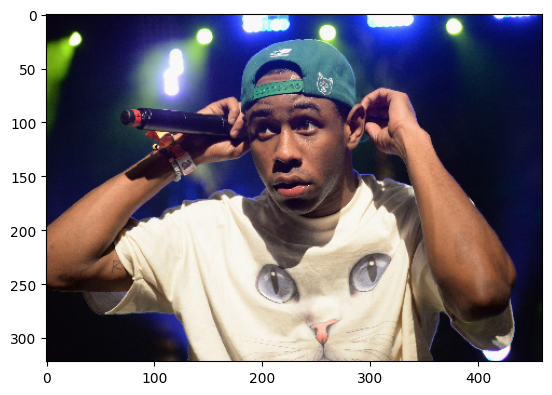

In [85]:
tyler = cv2.imread(rf'Data/tyler-the-creator.jpg')
tyler = cv2.resize(tyler, dsize =(0,0), fx=0.1, fy=0.1)
plt.imshow(cv2.cvtColor(tyler, cv2.COLOR_BGR2RGB))

In [86]:
mi, ma = np.min(np.subtract(np.int32(tyler),100)), np.max(tyler-100)
print(mi, ma)

-100 255


(322, 460, 3)


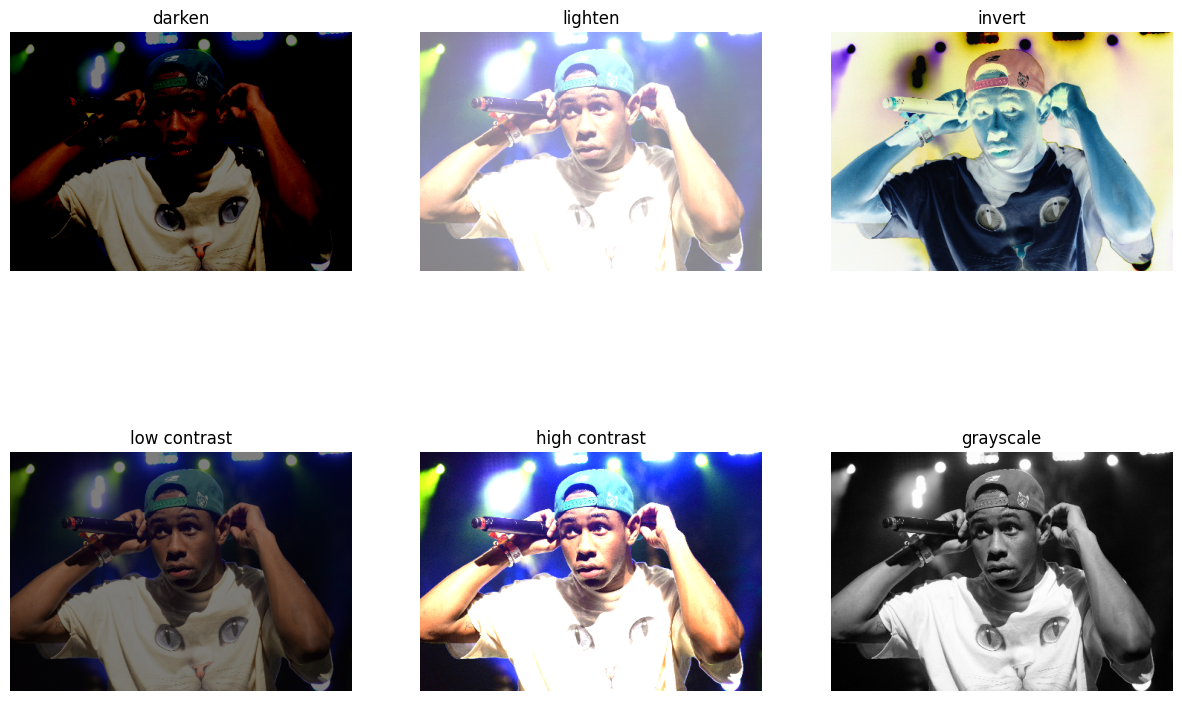

In [89]:
new_tyler = np.int32(cv2.cvtColor(tyler, cv2.COLOR_BGR2RGB))
modified_tylers = {
    'darken': np.clip(new_tyler - 128, 0, 255), # darken
    "lighten": np.clip(new_tyler + 128, 0, 255), # lighten
    'invert': 255 - new_tyler, # invert
    'low contrast': new_tyler // 2, # low contrast
    'high contrast': np.clip(new_tyler * 2, 0, 255), # high contrast
    'grayscale': (0.1 * tyler[...,0]) + (0.6 * tyler[...,1]) +(0.3 * tyler[...,2]) # grayscale
}
print(modified_tylers['darken'].shape)
fig, ax = plt.subplots(2,3, figsize=(15,10))
for i, (name, image) in enumerate(modified_tylers.items()):
    if i < 5:
        ax[i//3][i%3].imshow(image)
    else:
        ax[1][2].imshow(image, cmap='gray', label = name)
    ax[i//3][i%3].set_title(name)    
    ax[i//3][i%3].axis('off')

**Linear Shift-Invariant Systems (LSIS)**

First we'll look at how LSISs work on 1D signals as it can be abstracted later into more dimensions. An LSIS is a system that ensures 2 properties where $f(x) -> LSIS -> g(x)$:
1. Linearity
    - $f_1(x) \rightarrow LSIS \rightarrow g_1(x)$ and $f_1(x) \rightarrow LSIS \rightarrow g_1(x)$
    - $\implies \alpha f_1(x) + \Beta f_2(x) \rightarrow LSIS \rightarrow \alpha g_1(x) + \Beta g_2(x)$
2. Shift Invariance
    - $f(x) \rightarrow LSIS \rightarrow g(x) \implies f(x - a) \rightarrow LSIS \rightarrow g(x - a)$


An ideal lens is an example of an LSIS!

----

**Convolutions**

We define convolutions of two functions f(x) and h(x) as $g(x) = f(x) \ast h(x) = \int_{-\infty}^{\infty}f(\tau)h(x-\tau)d\tau$. To visualize this better, we'll look at different functions and the resulting transformations and convolutions they go through.



In [134]:
# A group of functions for showing convolutions on
def quad(x):
    return -(x**2)

def rect(x):
    return np.array([0 if i < 0 or i > 1 else 1 for i in x])

def triangle(x_arr):
    output = np.zeros_like(x_arr)
    for i, x in enumerate(x_arr):
        if x < 0 or x > 2:
            output[i] = 0
        elif x <= 1:
            output[i] = x
        else:
            output[i] = 2 - x

    return output
    
def sin_wave(x, amp):
    return amp * np.sin(x)

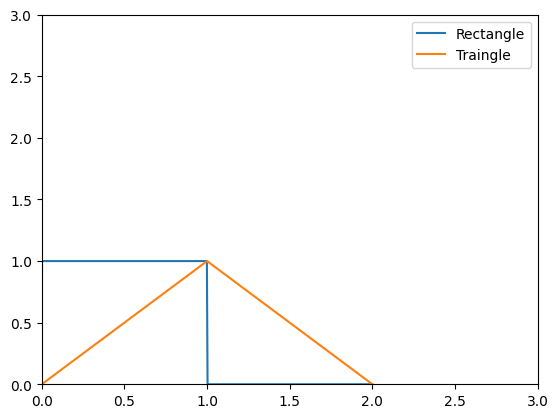

In [153]:
x1 = np.linspace(-2,2,1000)
y1 = rect(x1)

x2 = np.linspace(-2,2,1000)
y2 = triangle(x2)

fig, ax = plt.subplots()
ax.plot(x1, y1, label='Rectangle')
ax.plot(x2, y2, label='Traingle')
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.legend()
plt.show()

In [155]:
print(np.max(np.convolve(y2, y1, mode='same'))/250)

0.74974974974975


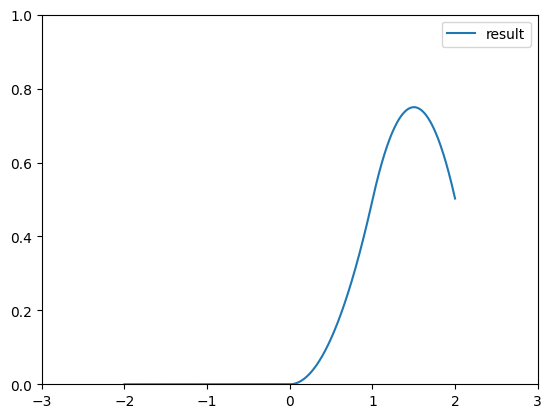

In [156]:
new_x =np.linspace(-2, 2, 1000)
conv = np.convolve(y1, y2, mode='same')/250
fig, ax = plt.subplots()
ax.plot(new_x, conv, label='result')
ax.set_xlim(-3, 3)
ax.set_ylim(0, 1)
plt.legend()
plt.show()

We can also show that convolutions preserve both linearity and shift-invariance. 

1. $g_1(x) = \int_{-\infty}^{\infty}f_1(\tau)h(x-\tau)d\tau$ & $g_2(x) = \int_{-\infty}^{\infty}f_2(\tau)h(x-\tau)d\tau$  

    $\implies \int_{-\infty}^{\infty}(\alpha f_1(\tau) + \Beta f_2(\tau))h(x-\tau)d\tau$ 

    $= \int_{-\infty}^{\infty}\alpha f_1(\tau)h(x-\tau)d\tau + \int_{-\infty}^{\infty}\Beta f_2(\tau)h(x-\tau)d\tau$ 

    $= \alpha g_1(x) + \Beta g_2(x)$
2. Let, $g(x) = \int_{-\infty}^{\infty}\alpha f(\tau)h(x-\tau)d\tau$
    
    Then, $\int_{-\infty}^{\infty}\alpha f(\tau - a)h(x-\tau)d\tau$ 
    
    $= \int_{-\infty}^{\infty}\alpha f(\mu)h(x-a-\mu)d\mu | \mu = \tau-a$
    
    $= g(\mu) = g(\tau - a)$

Both linearity and shift invariance are preserved $\therefore convolution \implies LSIS$


--------

If h is unkown, how can we find the function by adjusting f s.t. $h(x) = f(x) \ast h(x)$. We can assign f to be the *Unit Impulse Function* as defined by:

$$
\delta(x) = \left\{
\begin{array}{ll}
\frac{1}{2\varepsilon}, & |x| \leq \varepsilon \\
0, &|x| \gt  \varepsilon \\
\end{array}
\right.
$$

This function has the sifting property where, because $\delta$ has an area of 1 and is symmetric, convolving any function $b(x)$ results in the output being $b(x)$. Formally we say $\int_{-\infty}^{\infty}\delta(\tau)b(x-\tau)d\tau = b(x)$.

**Linear Image Filter**

Convolutions on discrete images can be represented as a sum:
$$g[i, j] = \sum_{m=1}^{M}sum_{n=1}^{N} f[m,n]h[i-m,j-n]$$

In this formula, *h* acts as the kernel (a.k.a the mask or filter). We process the image by convolving each pixel with *h* with raster scanning. Unfortunately, at the border the kernel cannot properly function leaving us with 3 options (for now at least, of course there are other padding options):
1. Ignore the border
2. Pad with constant value
3. Pad with reflection

Let's look at an example with some exaggerated parameters

<function matplotlib.pyplot.show(close=None, block=None)>

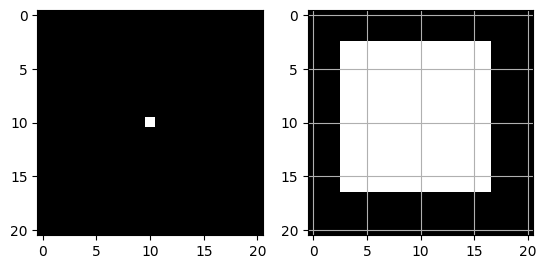

In [218]:
impulse_filter = np.zeros(shape=(21,21,3))
impulse_filter[10, 10,:] = 1

box_filter = np.zeros_like(impulse_filter)
box_filter[3:17, 3:17,:] = 1/225

fig, ax = plt.subplots(1, 2)
ax[0].imshow(impulse_filter[:,:,0],cmap = 'gray')
ax[1].imshow(box_filter[:,:,0],cmap = 'gray')
plt.grid()
plt.show


In [224]:
def raster_convolve(image, kernel, pad):
    H, W, _ = image.shape
    kh, kw, _ = kernel.shape
    if kh % 2 == 0 or kw != kh:
        raise Exception(f'This function only supports square, odd sized kernels but recieved shape:{kernel.shape}')
    
    padx, pady = kh//2,kw//2
    output = np.zeros_like(image)

    if pad == 'none':
        for i in  range(padx, H - padx):
            for j in range(pady, W - pady):
                output[i,j] = np.sum(kernel * image[(i-padx):(i+padx+1), (j-pady):(j+pady+1)], axis=(0,1))
        return output
    if pad == 'constant':
        image = np.pad(image, ((padx, padx), (pady, pady), (0, 0)), 'constant', constant_values=1)
    if pad == 'reflect':
        image = np.pad(image, ((padx, padx), (pady, pady), (0, 0)), 'reflect')
    
    for i in range(padx, H + padx):
        for j in range(pady, W + pady):
            output[i - padx, j - pady] = np.sum(kernel * image[(i-padx):(i+padx+1), (j-pady):(j+pady+1)], axis=(0,1))

    return output

    

In [225]:
padded_images = {
    'impulse_constant' : raster_convolve(tyler, impulse_filter, 'constant'),
    "boxed_none" : raster_convolve(tyler, box_filter, 'none'),
    'boxed_reflected' : raster_convolve(tyler, box_filter, 'reflect')
}


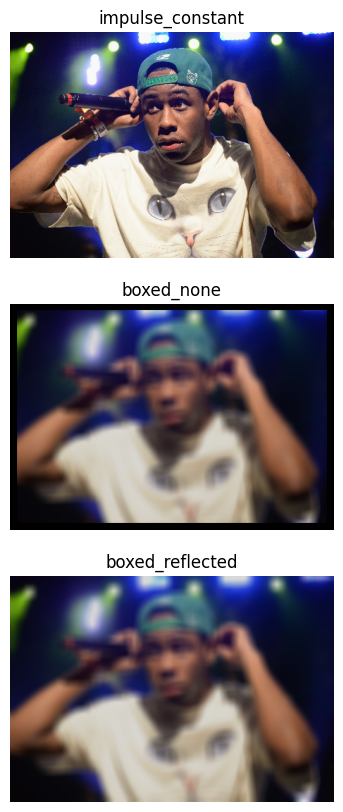

In [230]:
fig, ax = plt.subplots(3,1, figsize=(15,10))
for i, (name, img) in enumerate(padded_images.items()):
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')
    ax[i].set_title(name)

plt.show()

As you can see, the padding helps avoid any boundary issues the filter may cause by skipping the first few pixels. There is, however, artifacting present in final box filter application due to the boxy nature of the filter itself. Here's a closeup look at what this filter produces:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333333333333333].


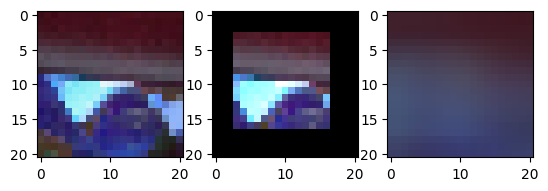

In [232]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(tyler[100:121, 100:121, :])
ax[1].imshow((box_filter * tyler[100:121, 100:121, :]))
ax[2].imshow(raster_convolve(tyler[100:121, 100:121, :], box_filter, pad='reflect'))

To avoid this artifacting, we need to place more importance on the center pixel and taper off the weights as we reach the borders of our filter. We can use a *Gaussian Kernel* as our fuzzy filter and can represent it as
$$n_{\sigma}[i,j] = \frac{1}{2\pi\sigma^2}e^{-\frac{1}{2}(\frac{i^2 +j^2}{\sigma^2})} | \sigma \text{ is standard deviation and } \sigma^2 \text{ is variance}$$

With our discrete images, we can write our convolution as such:

$$g[i,j] =  \frac{1}{2\pi\sigma^2} \sum_{m=1}^{k} \sum_{n=1}^{k} e^{-\frac{1}{2}(\frac{m^2 +n^2}{\sigma^2})}f[i-m, j-n]$$

Luckily, Gaussian smoothing is separable! $\therefore$ Using 1 2D Gaussian filter $\equiv$ Using 2 1D Gaussian filters!

$$g[i,j] =  \frac{1}{2\pi\sigma^2} \sum_{m=1}^{k} e^{-\frac{1}{2}(\frac{m^2}{\sigma^2})}\sum_{n=1}^{k} e^{-\frac{1}{2}(\frac{n^2}{\sigma^2})}f[i-m, j-n]$$

Our ideal $\sigma$ can be determined from our kernel size where $k \approx 2\pi\sigma$. In the following few cells, we'll explore how Gaussian blurring works and how can take advantage of its separable property.

Naive 2D implementation: 3.19052 seconds
Separable implementation: 0.00531 seconds
OpenCV implementation: 0.00421 seconds
Speed up from sepFilter2D: 600.925x faster
Speed up from GaussianBlur: 758.660x faster


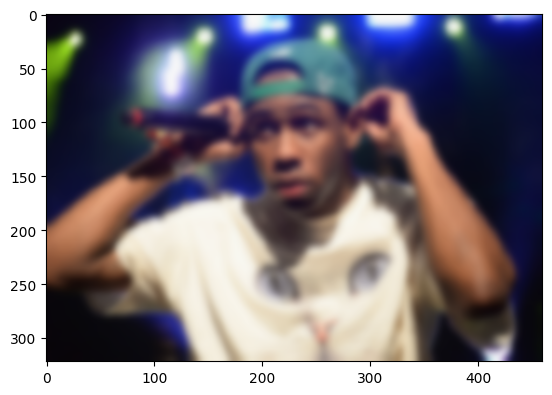

In [247]:
# Make 1D and 2D Gaussian
gaussian_1D = cv2.getGaussianKernel(21, sigma=0)
gaussian_2D = gaussian_1D @ gaussian_1D.T
gaussian_3D = np.repeat(gaussian_2D[:,:, np.newaxis], 3, axis=2)

# Run 2D raster convolution
begin = time.time()
gau_blurred = raster_convolve(tyler, gaussian_3D, pad='reflect')
end = time.time()
speeds1 =(end - begin)

begin = time.time()
gau_blurred = cv2.sepFilter2D(tyler, -1, gaussian_1D, gaussian_1D.T)
end = time.time()
speeds2 =(end - begin)

begin = time.time()
gau_blurred = cv2.GaussianBlur(tyler, ksize=(21,21), sigmaX=0, sigmaY=0)
end = time.time()
speeds3 = (end - begin)

print(f'Naive 2D implementation: {speeds1:.5f} seconds')
print(f'Separable implementation: {speeds2:.5f} seconds')
print(f'OpenCV implementation: {speeds3:.5f} seconds')
print("==============================================")
print(f'Speed up from sepFilter2D: {speeds1/speeds2:.3f}x faster')
print(f'Speed up from GaussianBlur: {speeds1/speeds3:.3f}x faster')

plt.imshow(cv2.cvtColor(gau_blurred, cv2.COLOR_BGR2RGB))

It's clear to see just how much of an improvement separating the filtering process is. We know it will be faster to run 2 1D convolutions because of the number of operations (FLOPs for fun aka FLoating-point OPerations) is far lower. In fact, we can show this

<div style="margin-left: auto;
            margin-right: auto;
            width: 30%">

|1 2D Convolution               |2 1D Convolutions            |         
|-------------------------------|-----------------------------|         
|$k^2$ multiplications          |$2k$ multiplications         |         
|$k^2 - 1$ additions            |$2(k - 1)$ additions         |

</div>       

------

**Non-Linear Image Filtering**

Sometimes, however, linear filters aren't enough. Because of their linear nature, they cannot differentiate between outliers and foreground. In the next few cells we'll explore how increasing noise affects blurring results and some alternatives.

In [282]:
def make_salty_and_peppery(image, amount=0.05):
    seasoned_image = image.copy()
    H, W, _ = image.shape
    pixels = int(H * W * amount)
    coords = [np.random.randint(0, i - 1, pixels) for i in (H, W)]
    seasoned_image[coords[0], coords[1], :] = 255

    coords = [np.random.randint(0, i - 1, pixels) for i in (H, W)]
    seasoned_image[coords[0], coords[1], :] = 0

    return seasoned_image

def make_noisy(image, sd=50):
    noisy = image.copy()
    noise = np.random.normal(0, sd, image.shape)
    noisy = np.clip(noisy + noise, 0, 255).astype(np.uint8)
    return noisy

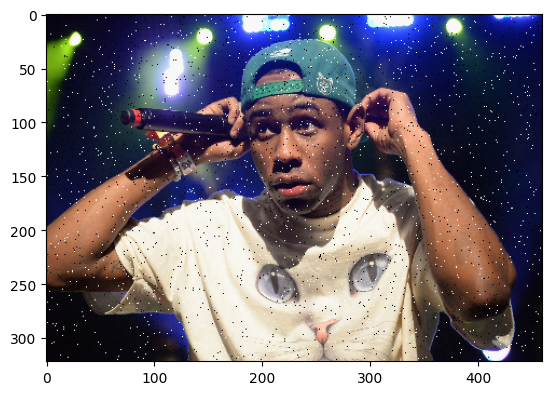

In [260]:
seasoned_tyler = cv2.cvtColor(make_salty_and_peppery(tyler, amount = 0.01), cv2.COLOR_BGR2RGB)
plt.imshow(seasoned_tyler)

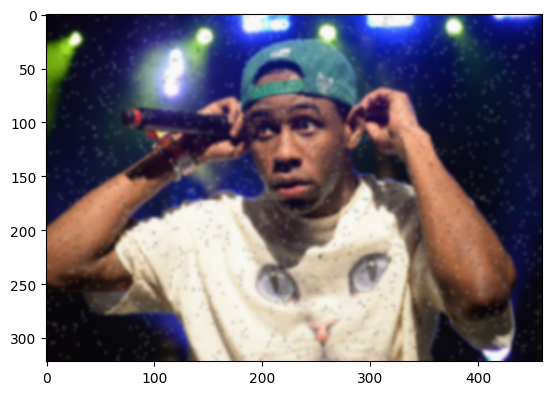

In [263]:
blurry_szn = cv2.GaussianBlur(seasoned_tyler, ksize=(7,7), sigmaX=0, sigmaY=0)
plt.imshow(blurry_szn)

As we can see, the blurring only sort of helps with the noise at the cost of image sharpness. If we can find filters that adjust weights based on the important of each pixel, then we can remove outliers with greater success. One such non-linear method is Median Filtering.

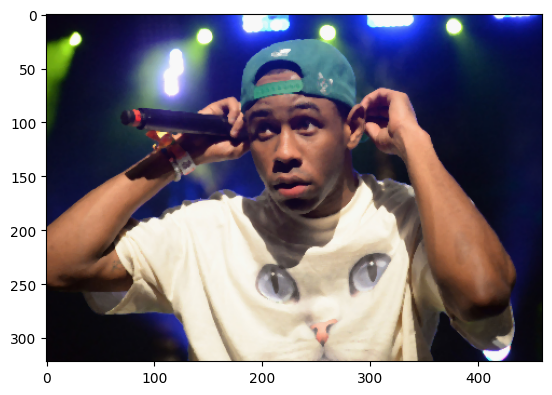

In [271]:
median_tyler = cv2.medianBlur(seasoned_tyler, ksize=3)
plt.imshow(median_tyler)

Let's take a more typically noisy image. Here we'll notice that no smoothing methods truly work well as they cannot take into respect the context around the pixel of interest. Instead

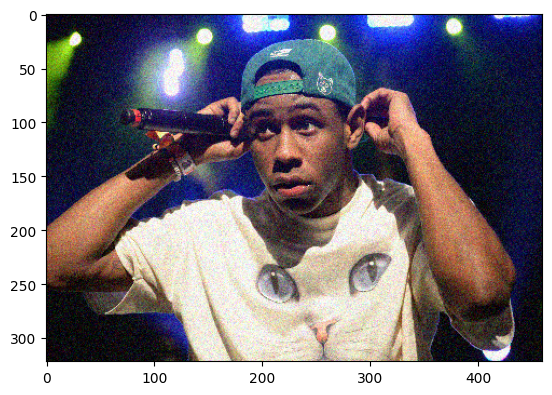

In [287]:
loud_tyler = cv2.cvtColor(make_noisy(tyler, sd=20), cv2.COLOR_BGR2RGB)
plt.imshow(loud_tyler)

To build in a way to look at context, we'll compare only similarly intense pixels and adjust the output based on those closest in intensity. This type of filtering is called Bilateral Filtering! We can define the filter as such:

$$g[i,j] = \frac{1}{W_{sb}}\sum_{m}\sum_{n}f[m,n]n_{\sigma_{s}}[i-m,j-n]n_{\sigma_{b}}(f[m,n] - f[i,j])$$
$$\text{Where } W_{sb} = \sum_{m}\sum_{n}n_{\sigma_{s}}n_{\sigma_{b}}$$

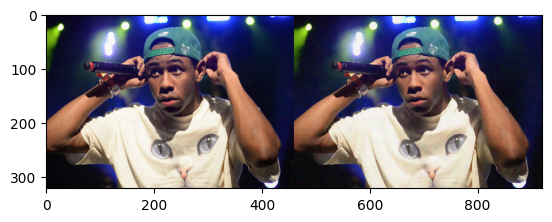

In [299]:
bilateraled_tyler = cv2.bilateralFilter(loud_tyler, -1, sigmaColor=50, sigmaSpace=4)
plt.imshow(np.hstack([cv2.cvtColor(tyler, cv2.COLOR_BGR2RGB), bilateraled_tyler]))

With the original on the right and the filtered result on the right, we can see that adding a brightness gaussian adds enough context to keep the sharpness from the original image.